In [27]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split

In [4]:
!gsutil cp gs://gresearch/slot-attention/object-discovery/* /kaggle/working/


Copying gs://gresearch/slot-attention/object-discovery/checkpoint...
Copying gs://gresearch/slot-attention/object-discovery/ckpt-500.data-00000-of-00001...
Copying gs://gresearch/slot-attention/object-discovery/ckpt-500.index...        
| [3 files][ 10.2 MiB/ 10.2 MiB]                                                
Operation completed over 3 objects/10.2 MiB.                                     


In [6]:
from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# %cd ../input/googleresearchslotattention

import data as data_utils
import model as model_utils

In [120]:
# Hyperparameters.
seed = 0
batch_size = 1
num_slots = 7
num_iterations = 3
resolution = (128, 128)
ckpt_path = "/kaggle/working/"  # Path to model checkpoint.

In [121]:
def load_model(checkpoint_dir, num_slots=11, num_iters=3, batch_size=16):
  resolution = (128, 128)
  model = model_utils.build_model(
      resolution, batch_size, num_slots, num_iters,
      model_type="object_discovery")

  ckpt = tf.train.Checkpoint(network=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, directory=checkpoint_dir, max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)

  return model

In [122]:
# Build dataset iterators, optimizers and model.
tf.random.set_seed(seed)

model = load_model(ckpt_path, num_slots=num_slots, num_iters=num_iterations,
                   batch_size=batch_size)
model


In [123]:
original_path = '/kaggle/input/combineddataset/original'
df = pd.read_csv('/kaggle/input/combineddataset/text_label.csv')
train, test = train_test_split(df, test_size=0.005, random_state = 42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
len(test)

30

In [124]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch_image, idx=0):
  recon_combined, recons, masks, slots = model(batch_image)
  image = renormalize(batch_image)[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots
    

In [125]:
def visualize(image, recon_combined, recons, masks, slots):
    num_slots = len(masks)
    fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(recon_combined)
    ax[1].set_title('Recon.')
    for i in range(num_slots):
      ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
      ax[i + 2].set_title('Slot %s' % str(i + 1))
    for i in range(len(ax)):
      ax[i].grid(False)
      ax[i].axis('off')
    plt.show()

In [126]:
def preprocess(img_name):
    n = img_name.split("_")
    original_name = n[0] + "_" + n[1]
    img = cv2.imread(os.path.join(original_path, original_name + ".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resolution)
    img = np.asarray(img, np.float32)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = ((img / 255.0) - 0.5) * 2.0
    img = tf.clip_by_value(img, -1., 1.)
    img = tf.expand_dims(img, axis=0)
#     image =  renormalize(img)
#     image = image.numpy()
#     plt.imshow((image*255.0).astype('uint8'))
#     plt.show()
#     print(image.shape)
    return img

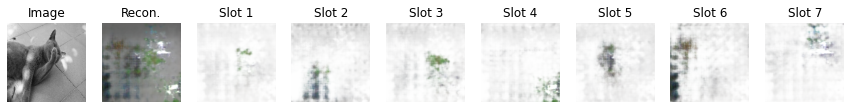

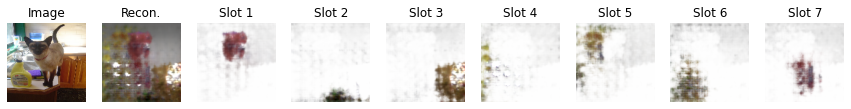

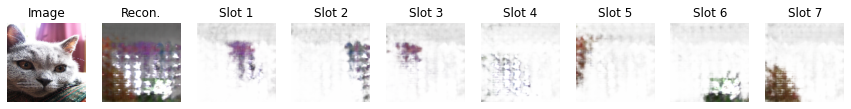

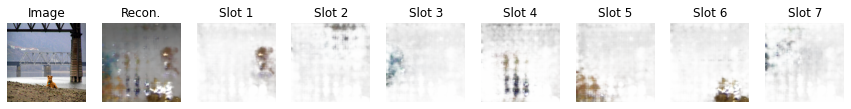

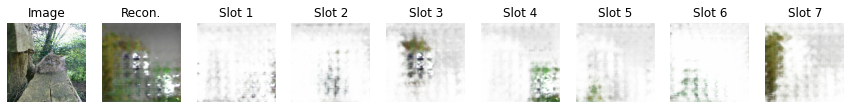

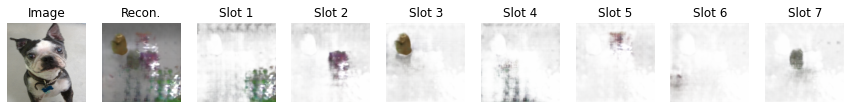

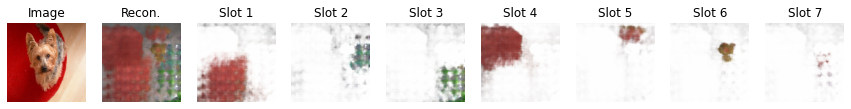

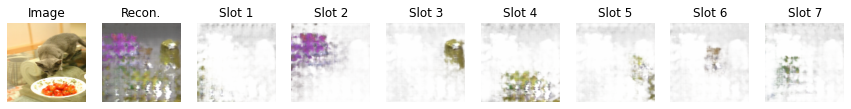

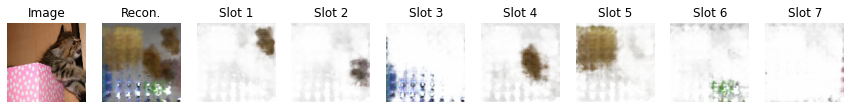

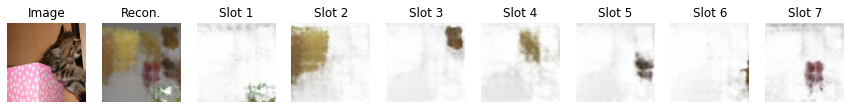

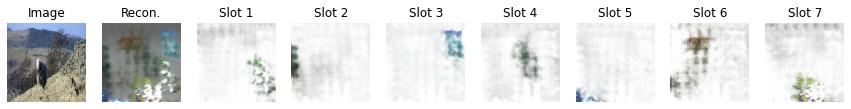

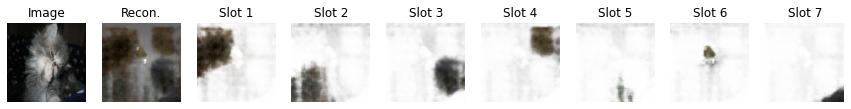

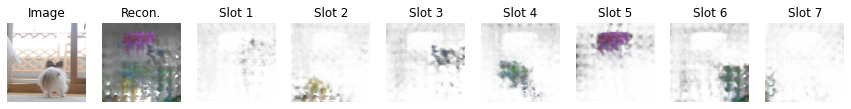

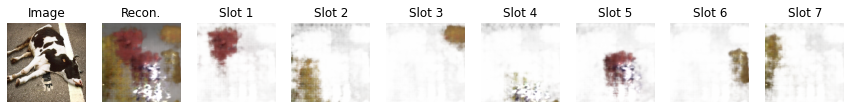

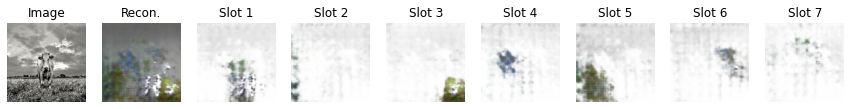

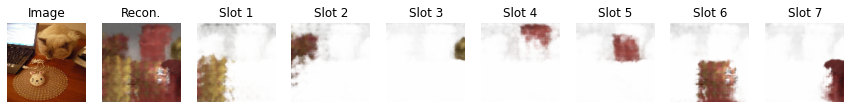

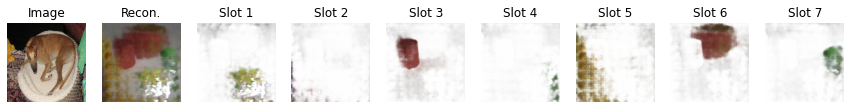

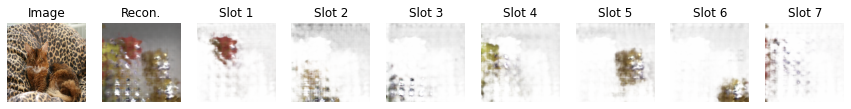

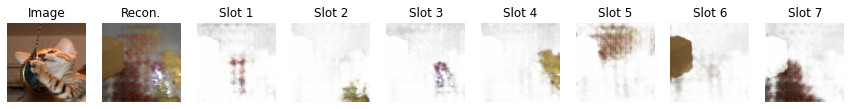

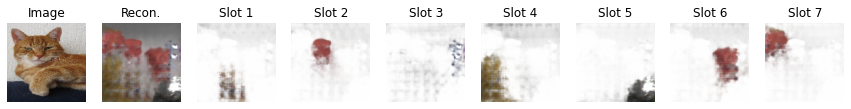

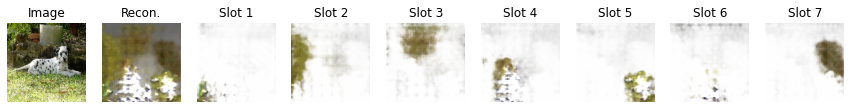

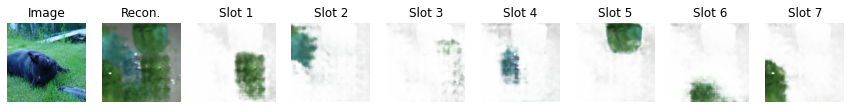

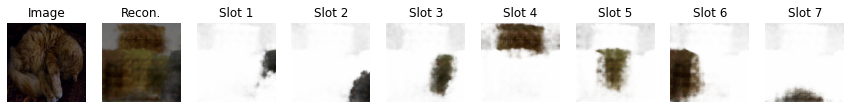

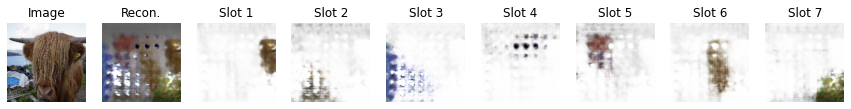

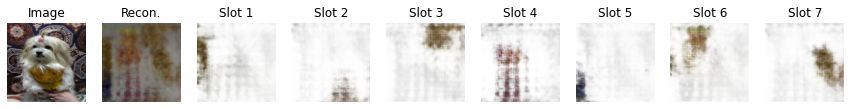

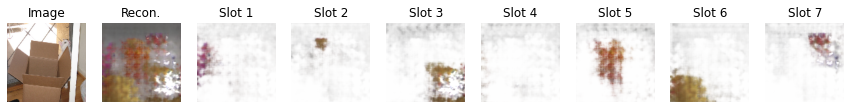

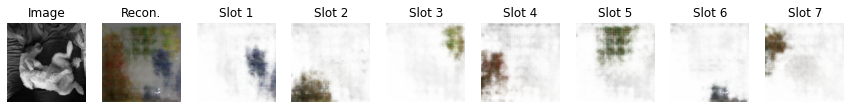

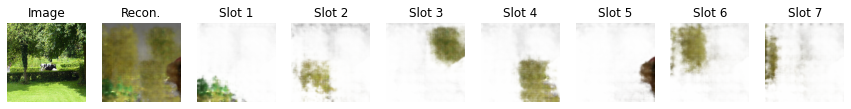

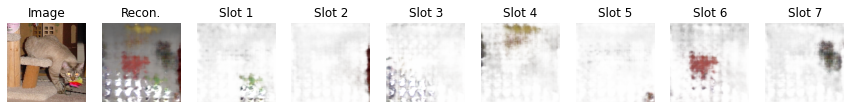

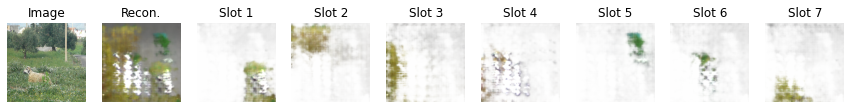

In [127]:



for img_name in test.name:
    batch_image = preprocess(img_name)
    image, recon_combined, recons, masks, slots = get_prediction(model, batch_image)
    visualize(image, recon_combined, recons, masks, slots)
    
